In [1]:
%matplotlib inline
import tensorflow as tf
from functools import partial

import sys
import os
if 'utils' in os.listdir('../../'):
    sys.path.append("../../")
    from utils.dataset import SerializationDataset
else:
    !pip install wget
    !git clone https://github.com/you-just-want-attention/all-about-mnist.git
    sys.path.append("./all-about-mnist/")
    from utils.dataset import SerializationDataset
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from tqdm import tqdm

from tf_models.text_recognition.models import CRNN
from tf_models.text_recognition.generator import DataGenerator

Using TensorFlow backend.


### [Optional.  Tensorflow Graph Visualization ]

---

> _Jupyter에서 Tensorflow에서 구성되는 Graph를 시각적으로 보여주기 위한 helper 메소드입니다._<br>

In [2]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))

    display(HTML(iframe))

### Graph 만들기
----


In [4]:
crnn = CRNN()

# Model Graph 구성하기
(crnn
 ._attach_cnn_network(num_features=16)
 ._attach_rnn_network(num_features=128)
 ._attach_transcription()
 ._attach_metric()
 ._attach_optimizer()
)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
show_graph(crnn.graph)


모델 학습시키기
----

### 1) 데이터 셋 가져오기 

In [7]:
train_set = SerializationDataset('mnist','train',
                                 digit=5,pad_range=(3,10))
validation_set = SerializationDataset('mnist','validation',
                                      digit=5,pad_range=(3,10))
test_set = SerializationDataset('mnist','test',
                                digit=(3,8),pad_range=(3,10))

### 2) 데이터 Generator 구성하기

In [8]:
train_gen = DataGenerator(train_set,batch_size=32)
valid_gen = DataGenerator(validation_set,batch_size=100, shuffle=False)
test_gen = DataGenerator(test_set,batch_size=500, shuffle=False)

test_images, test_labels = test_gen[0]

### 3) 학습시키기

In [9]:
num_epochs = 3
num_batch = 32
learning_rate = 0.001

crnn.fit_generator(train_gen, valid_gen, 
                   num_epoch=100,
                   learning_rate=0.001,
                   summary_path='.logs/')

100%|██████████| 343/343 [01:53<00:00,  3.02it/s]


[  0epoch]
Train ler :0.358 loss : 4.762


  0%|          | 0/343 [00:00<?, ?it/s]

Valid ler :0.000 loss : 0.142


  3%|▎         | 12/343 [00:04<01:50,  2.98it/s]


KeyboardInterrupt: 

### 4) 결과 확인하기

In [19]:
outputs = crnn._session.run(crnn._pred,feed_dict={
    crnn._x : test_images[:5]
})

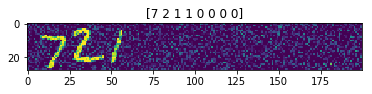

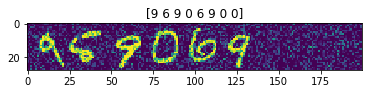

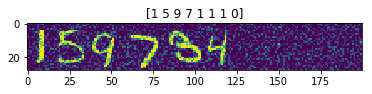

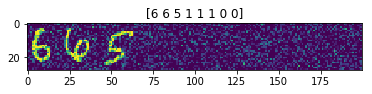

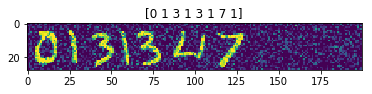

In [20]:
for output, image in zip(outputs, test_images):
    plt.title(output)
    plt.imshow(image[:,:,0])
    plt.show()